# **Intro**
In this notebook I set up conditional semi-supervised VAE that attempts to predict the proportions of MNIST numbers that have been superimposed on top of one another.

This is similar to the DIVA, where we use the rotation as labels and instead of having partially labeled numbers, we will have partially labeled number proportions. 
In that setup some labels are ommited to make it semi-supervised, which we will also do.
This will mimic the idea that we have bulk case vs. control examples (we don't know the proportions) and  simulate bulk samples from single-cell profiles, (where we don't have treatment data).
Using both of these sources of data we hope that we can work in OOD stuff.
Also, we use the M1+M2 formulation of semi-supervised as described here: "Semi-supervised Learning with Deep Generative Models", https://arxiv.org/abs/1406.5298

The difference in this model are the following: 


1.   We are learning proportions of numbers in an image, not a specific number.
This means that this is regression, not classification.
2.   We put the constraint directly on mu, not on an external classifier.
This is because we want to be able to augment mu and reconstruct in a logical manner.
For example, we want to be able to simulate the mixture of specific cell types by augmenting mu.
3.   We add in an additional classification loss for classification of treated vs. untreated.
We hope that by learning two separate processes (stack proportions and case/control classification) we will have enough information to compose them and handle out-of-distribution responses.
This did not work when we simply used the treatment as a condition, instead we will need to have a downstream classifier, linked to z, that will predict treatment status.



A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/




# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [2]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [3]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 12
-rw-r--r-- 1 root root  43 Aug 24 21:40 config
-rw------- 1 root root 432 Aug 24 21:40 id_rsa
-rw-r--r-- 1 root root 113 Aug 24 21:40 id_rsa.pub


In [4]:
%%bash
# do your git operations here

git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   experiments/rotated_example_ssDIVA_mnist.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	experiments/rotated_example_supervisedDIVA_mnist.ipynb
	experiments/rotated_example_supervisedDIVA_semiconditional_mnist.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


# **Imports**

In [5]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

# tensorflow probability additions for the priors
#from tensorflow_probability.distributions import Independent
#from tensorflow_probability.distributions import Normal
#from tensorflow_probability.layers import IndependentNormal
#from tensorflow_probability.layers import KLDivergenceAddLoss

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# load methods from other files
from mnist_preprocessing import generate_data as gd

# I disable eager execution ... forgot why
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# **Load / Pre-process data**
Import + reshape the non-rotated MNIST data

In [6]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
Y_train = to_categorical(Y_train)

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

print(Y_train)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Import + reshape and rotate MNIST data.
In our single-cell analogy, rotation is a treatment and the number value is a cell-type.

In [7]:
(X_train_r, Y_train_r), (X_test_r, Y_test_r) = mnist.load_data()
Y_train_r = to_categorical(Y_train_r)
# now add in the rotation
def rotate_90(img):
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

def rotate_deg(in_img, angle):
  img = Image.fromarray(np.uint8(in_img) , 'L')
  img = img.rotate(angle)
  return np.asarray(img)

def rotate_data(X_train, Y_train, X_test, Y_test, angle):
  # rotate the training data
  X_train_15 = np.array([rotate_deg(xi, angle) for xi in X_train_r])
  Y_train_15 = Y_train

  # rotate the test data
  X_test_15 = np.array([rotate_90(xi) for xi in X_test_r])
  Y_test_15 = Y_test

  # reshape the data
  X_train_15 = X_train_15.astype('float32') / 255.
  X_test_15 = X_test_15.astype('float32') / 255.

  n_pixels = np.prod(X_train_15.shape[1:])
  X_train_15 = X_train_15.reshape((len(X_train_15), n_pixels))
  X_test_15 = X_test_15.reshape((len(X_test_15), n_pixels))

  return (X_train_15, Y_train_15, X_test_15, Y_test_15)

X_train_15, Y_train_15, X_test_15, Y_test_15 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 15)
X_train_30, Y_train_30, X_test_30, Y_test_30 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 30)
X_train_45, Y_train_45, X_test_45, Y_test_45 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 45)
X_train_60, Y_train_60, X_test_60, Y_test_60 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 60)
X_train_75, Y_train_75, X_test_75, Y_test_75 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 75)



Demo the data, to make sure everything works

rotated 15


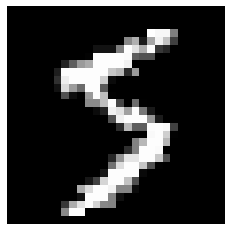

rotated 30


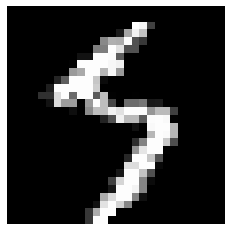

rotated 45


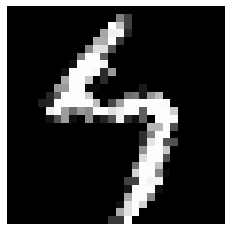

rotated 60


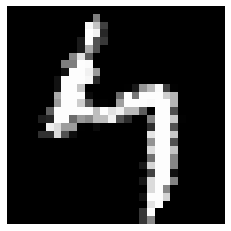

rotated 75


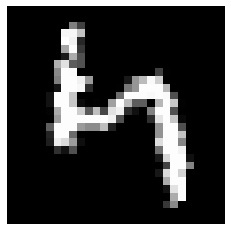

In [8]:
print("rotated 15")
plt.imshow(X_train_15[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 30")
plt.imshow(X_train_30[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 45")
plt.imshow(X_train_45[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 60")
plt.imshow(X_train_60[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 75")
plt.imshow(X_train_75[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# **Model Definition**


## Hyperparameters

In [9]:
run_prop_sampler = False

batch_size = 500
n_epoch = 20

alpha_rot = 1000000
alpha_prop = 100 ###

beta_kl_slack = 10
beta_kl_rot = 100
beta_kl_prop = 10

# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

n_x = X_train.shape[1]
n_y = Y_train.shape[1]
n_label = 6
n_label_z = 64

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")



length of X 784 and length of y 10 and n_label 6


## Inputs

In [42]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))

# concatenate input with the label 
input_s = X
input_p = concat([X, label]) ## we condition on the other info
input_r = concat([X, props]) ## we condition on the other info

## Encoder

In [43]:


# set up 3 independent encoder networks
# each one with a different purporse: slack, rotation, digit
# this is an encoder with 512 hidden layer

encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(input_s)
encoder_p = Dense(encoder_dim, activation=activ, name="encoder_prop")(input_p)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(input_r)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_prop = Dense(n_z, activation='linear', name = "mu_prop")(encoder_p)
l_sigma_prop = Dense(n_z, activation='linear', name = "sigma_prop")(encoder_p)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


## Latent Space

In [49]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_z])
z_prop = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_prop")([mu_prop, l_sigma_prop, n_z])
z_rot = Lambda(sample_z, output_shape = (n_label, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])

z_concat = concat([z_slack, z_prop, z_rot, props, label])

## Decoder + Classifiers

In [50]:


# define the decoder layers
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "d_out")

d_in = Input(shape=(n_z+n_z+n_label_z+n_label+n_y,), name="d_in")
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# link them together
h_p = decoder_hidden(z_concat)
outputs = decoder_out(h_p)


# proportion classifier
decoder_props = Softmax(name = "mu_prop_pred") # ReLU
prop_outputs = decoder_props(mu_prop)


# rotation classifier
rot_1_out = ReLU(name = "rot_h1")(z_rot)
rot_2_out = Dense(n_label, activation='linear', name = "rot_h2")(rot_1_out)
rotation_outputs = Softmax(name = "mu_rot_pred")(rot_2_out)





## Loss

In [46]:
def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.

    - accepts stacks of means, but only one S0 and S1

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl_prop = beta_kl_prop * K.sum(K.exp(l_sigma_prop) + K.square(mu_prop) - 1. - l_sigma_prop, axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_prop + kl_rot + kl_slack

def KL_loss(y_true, y_pred):
	return(beta_kl * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1) * alpha_prop


def prop_loss_unknown(y_true, y_pred):
  total_loss = 0
  for idx in range(0, 100): 
    y_temp = tf.random.shuffle(y_true)
    total_loss = total_loss + K.sum(K.binary_crossentropy(y_temp, y_pred), axis=-1)
  return total_loss / 1.

def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon


negloglik = lambda x, rv_x: -rv_x.log_prob(x)




## Make the computational graph

In [51]:

prob_vae = Model([X, label, props], [outputs, rotation_outputs, prop_outputs])
prob_vae.compile(optimizer=optim, loss=[recon_loss, class_loss, prop_loss])


encoder = Model([X, label, props], [z_slack, z_rot, mu_prop])

decoder = Model(d_in, d_out)

print(prob_vae.summary())


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 790)          0           input_7[0][0]                    
                                                                 input_8[0][0]             

# **Experimental Setup**

Now lets train and evaluate the model.
First we train with only some proportions of rotated 3's..
We will then decrease the proportion of rotated 3's in samples from 0.5 to 0.

In [17]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))


Setup the data so that we remove all the examples with a high proportion of rotated 3's

(360000, 784)
rotated 30


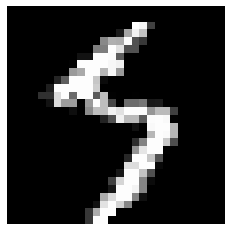

rotated 75


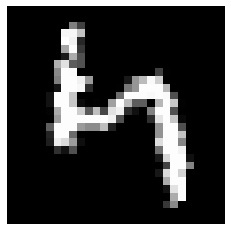

In [18]:
##################################################
#####. Design the experiment
##################################################

## 30 is unlabeled
## we test on 75

X_full = np.concatenate([X_train, X_train_15, X_train_30, X_train_45, X_train_60, X_train_75])
Y_full = np.concatenate([Y_train, Y_train_15, Y_train_30, Y_train_45, Y_train_60, Y_train_75])

print(X_full.shape)

### also create the condition label (degrees = label) 
n_train = Y_train.shape[0]
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                              np.full(n_train, 2), np.full(n_train, 3),
                              np.full(n_train, 4), np.full(n_train, 5)], axis=0)
label_full = to_categorical(Label_full)


idx_train = np.where(np.logical_and(Label_full!=2, Label_full!=5))[0]
idx_30 = np.where(Label_full==2)[0]
idx_75 = np.where(Label_full==5)[0]

print("rotated 30")
plt.imshow(X_full[idx_30[0],].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 75")
plt.imshow(X_full[idx_75[0]].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()


# for unknown proportions
X_unkp = X_full[idx_30,]
label_unkp = label_full[idx_30,]
y_unkp = Y_full[idx_30,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
y_kp = Y_full[idx_train,]


# test
X_75 = X_full[idx_75,]
label_75 = label_full[idx_75,]
y_75 = Y_full[idx_75,]



# now take a subsample of the full dataset
unkp_size = 50000
kp_size = 50000
unkp_rand_idx = np.random.choice(X_unkp.shape[0], size=unkp_size, replace=False)
kp_rand_idx = np.random.choice(X_kp.shape[0], size=kp_size, replace=False)



# **Training**

Now train

In [52]:

#prob_vae = Model([X, label, props], [outputs, rotation_outputs, prop_outputs])

# compile and fit
prob_vae_hist = prob_vae.fit([X_kp[kp_rand_idx,:], label_kp[kp_rand_idx,:], y_kp[kp_rand_idx,:]], 
                             [X_kp[kp_rand_idx,:], label_kp[kp_rand_idx,:], y_kp[kp_rand_idx,:]],
                             verbose = 1, batch_size=batch_size, epochs=n_epoch,
							              callbacks = [EarlyStopping(patience = 5)])

Epoch 1/20
100/100 [==============================] - 11s 103ms/step - loss: 351025.9688 - d_out_loss: 132.6514 - mu_rot_pred_loss: 350891.5938 - mu_prop_pred_loss: 1.5749
Epoch 2/20
100/100 [==============================] - 10s 104ms/step - loss: 18055.9805 - d_out_loss: 90.4482 - mu_rot_pred_loss: 17964.0430 - mu_prop_pred_loss: 1.4899
Epoch 3/20
100/100 [==============================] - 10s 103ms/step - loss: 8421.9492 - d_out_loss: 85.7352 - mu_rot_pred_loss: 8334.9922 - mu_prop_pred_loss: 1.2253
Epoch 4/20
100/100 [==============================] - 10s 103ms/step - loss: 4391.1499 - d_out_loss: 83.2046 - mu_rot_pred_loss: 4306.8101 - mu_prop_pred_loss: 1.1354
Epoch 5/20
100/100 [==============================] - 10s 103ms/step - loss: 2964.2954 - d_out_loss: 81.4228 - mu_rot_pred_loss: 2881.8640 - mu_prop_pred_loss: 1.0088
Epoch 6/20
100/100 [==============================] - 10s 103ms/step - loss: 2058.2046 - d_out_loss: 80.0681 - mu_rot_pred_loss: 1977.2437 - mu_prop_pred_loss

# **Inspect the output**

We will take two examples from our training and see how well it reconstructs.
We first look at the ground truth so we know what we should expect.

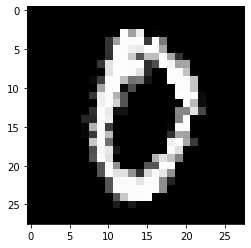

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0.]


In [29]:
plot_idx = 1

plt.imshow(X_unkp[plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(y_unkp[plot_idx])
print(label_unkp[plot_idx])


Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

In [33]:
plot_idx = 0

z_slack, z_rot, mu_prop = encoder.predict([X_full, label_full, Y_full], batch_size=batch_size)
encoded_X0 = mu_prop[plot_idx]
rotated_vec = z_rot[plot_idx]
print(f"1-hot encoded condition vector: {Y_full[plot_idx]}\n")

print(f"output from encoder: {encoded_X0}")

encoded_X0[encoded_X0<0] = 0
print(f"output from encoder (ReLU applied): {encoded_X0}")

print(f"rotation: {label_full[plot_idx]}")
print(f"rotation (noReLU applied): {rotated_vec}")
rotated_vec[rotated_vec<0] = 0
print(f"rotation (ReLU applied): {rotated_vec}")


1-hot encoded condition vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

output from encoder: [ -0.42924175  -3.62413      7.902622    13.910364   -21.901453
  19.472813    -7.955192    -3.9768248   -1.3341705    2.4870963 ]
output from encoder (ReLU applied): [ 0.         0.         7.902622  13.910364   0.        19.472813
  0.         0.         0.         2.4870963]
rotation: [1. 0. 0. 0. 0. 0.]
rotation (noReLU applied): [ 3.6168883   5.3668795   0.9342393   2.2128546  -1.4649035  -3.9844089
  1.3873758   4.7722974   3.9428952   3.1738856   1.9101715   3.0959902
  3.989017    5.998758    5.1183424  -0.24166498  1.9535328  -0.09687816
  1.5289303   2.3657498   2.6917977   4.3412814   6.962996    1.5405389
  0.07772099  1.5382608   2.8073053   1.29899     3.4572651   1.4004565
  2.6177123  -4.608168    7.094776    1.2230408   3.726582    1.1146632
  3.4304976   0.13960789 -3.2566078   8.055081    4.984208    4.6654654
  2.7795696   1.6558368   0.28274924 -4.1008306   4.0616455   2.766938
  

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 5.639483
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.240990
[t-SNE] KL divergence after 300 iterations: 2.050187
t-SNE done! Time elapsed: 15.015258312225342 seconds
(5000, 2)
(5000, 2)


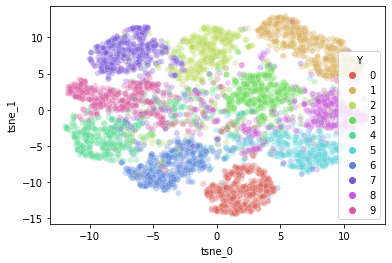

In [53]:
# plot proportions on unseen DATA
X_temp = X_full[idx_75,]
Y_temp = Y_full[idx_75,]
label_temp = label_full[idx_75,]

z_slack, z_rot, mu_prop = encoder.predict([X_temp, label_temp, Y_temp], batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.588s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 6.440465
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.732895
[t-SNE] KL divergence after 300 iterations: 1.947693
t-SNE done! Time elapsed: 14.695358514785767 seconds
(5000, 2)
(5000, 2)


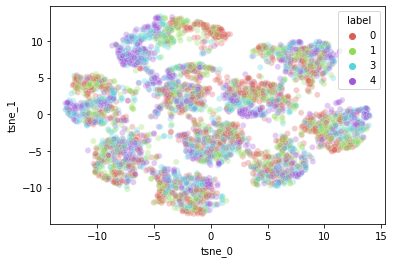

In [54]:
# plot proportions
X_temp = X_full[idx_train,]
Y_temp = Y_full[idx_train,]
label_temp = label_full[idx_train,]

z_slack, z_rot, mu_prop = encoder.predict([X_temp, label_temp, Y_temp], batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)




(5000, 2)
(5000, 2)


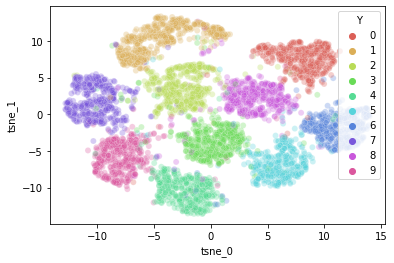

In [55]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)





[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.036s...
[t-SNE] Computed neighbors for 5000 samples in 1.765s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.264770
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.025269
[t-SNE] KL divergence after 300 iterations: 1.968707
t-SNE done! Time elapsed: 13.95534086227417 seconds
(5000, 2)
(5000, 2)


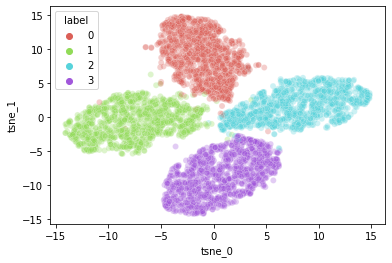

In [57]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.678s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 5.439595
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.744888
[t-SNE] KL divergence after 300 iterations: 2.405869
t-SNE done! Time elapsed: 16.856729745864868 seconds
(5000, 2)
(5000, 2)


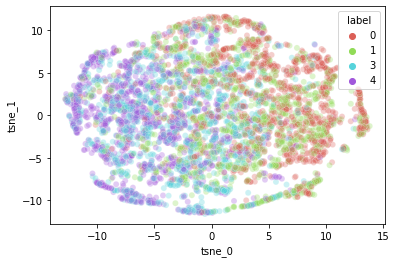

In [58]:
# plot remaining variance
z_test = z_slack
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)


(5000, 2)
(5000, 2)


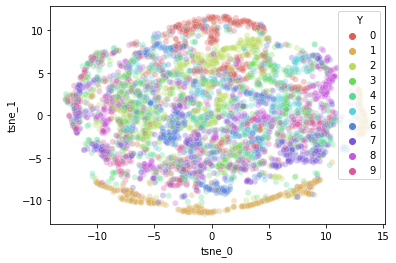

In [59]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)


In [ ]:
### NEED TO UPDATE
def method_sample_z(args):
    mu, l_sigma = args
    eps = np.random.normal(size=(batch_size, n_z), loc=0., scale=1.)
    return mu + np.exp(l_sigma / 2) * eps

def sample_digit(digit, rot_idx, X_test, Y_test, label_test, digit_scale):
  #z_slack, z_prop, z_rot, props, label
  z_slack, z_rot, mu_prop = encoder.predict([X_temp, label_temp, Y_temp], batch_size=batch_size)

  slack_input = [0,0,0,0,0,0,0,0,0,0]

  digit_input = [0,0,0,0,0,0,0,0,0,0]
  digit_input[digit] = 1*digit_scale

  rot_input = [0,0,0,0,0,0]
  rot_input[rot_idx] = 1*digit_scale

  rand_idx = np.random.choice(pred_input.shape[0], size=batch_size, replace=False)
  pred_input = pred_input[rand_idx]

  
  return(z_0_digit)


def sample_digit(digit, X_test, Y_test, digit_scale):
  digit_idx = np.where(Y_test == digit)

  pred_input = X_test[digit_idx[0]]
  rand_idx = np.random.choice(pred_input.shape[0], size=batch_size, replace=False)
  pred_input = pred_input[rand_idx]

  test_X, test_mu, test_label, test_lsigma = known_prop_vae.predict(pred_input, batch_size=batch_size)

  encoded_X0 = np.ones(10)*0.0001
  encoded_X0[digit] = digit_scale
  rand_lsigma = np.random.random_integers(low = 0, high = 249)
  z_0_digit = method_sample_z([encoded_X0, test_lsigma])
  z_0_digit = z_0_digit[rand_lsigma].reshape((1,10))
  return(z_0_digit)


digit_img = 3

Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_full[idx_train,]

keep_rot_idx = np.where(Y_temp == digit_img)[0]
print(sum(keep_rot_idx))
X_example = X_temp[keep_rot_idx,]
z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

z_0_digit = sample_digit(digit_img, X_temp, Y_temp, 10)
plt.figure(figsize=(3, 3))

# it is rotated
rotate_1hot = np.zeros(n_label_z)

# slack, prop, rot
slack_sample = [0,0,0,0,0,0,0,0,0,0]
pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,n_label_z+n_z+n_z))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

# it is rotated
rotate_1hot = np.zeros(n_label_z)
pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,n_label_z+n_z+n_z))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

In [ ]:
img_it = 0
sides = 10
slack_sample = [0,0,0,0,0,0,0,0,0,0]
rotate_scale = 10.


Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_full[idx_train,]

rotate_1hot =  np.zeros(n_label_z)
for i in range(0, sides):
    for j in range(0, sides):
        z_0_digit = sample_digit(i, X_temp, Y_temp, 2**j)

        digit_img = i

        keep_rot_idx = np.where(Y_temp == digit_img)[0]
        X_example = X_temp[keep_rot_idx,]
        z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

        # slack, prop, rot
        slack_sample = z_slack[0]
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,n_label_z+n_z+n_z))

        decoded = decoder.predict(pred_input)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()


rotate_1hot = np.zeros(n_label_z)
img_it = 0
sides = 10
for i in range(0, sides):
    for j in range(0, 6):
        rotate_1hot = np.zeros(n_label_z)
        rotate_1hot[j] = alpha_rot
        z_0_digit = sample_digit(i, X_temp, Y_temp, 2**4)
        digit_img = i

        keep_rot_idx = np.where(Y_temp == digit_img)[0]
        X_example = X_temp[keep_rot_idx,]
        z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

        # slack, prop, rot
        slack_sample = z_slack[0]
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,n_label_z+n_z+n_z))

        decoded = decoder.predict(pred_input)
        subplot(sides, 6, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

In [ ]:
# predict rotated numbers

# normalizing the data to make the neural network easier to learn
x_train_r = normalize(X_train_r, axis=1)
x_test_r = normalize(X_test_r, axis=1)

#choosing the sequential model
classification_model = Sequential()

#defining the architecture of the model
X_class = Input(shape=(n_x,))
classification_model.add(X_class)
classification_model.add(Dense(512, activation='relu'))
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
classification_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#training the model
classification_model.fit(x_train_r,Y_train_r,epochs=5)

In [ ]:

num_correct = 0
num_digits = 10
num_rep = 100
rotate_1hot = np.array([0., 10])
rotate_val = True
slack_sample = method_sample_z([0,1])[0]
acc = []
for digit_idx in range(0, num_digits):
  num_correct = 0
  for idx_rep in range(0, num_rep):
    z_0_digit = sample_digit(digit_idx, Y_test, 2**6, rotate=rotate_val)
    digit_img = digit_idx

    keep_rot_idx = Y_full_test[:,digit_img] > 0.7
    X_example = X_full_test[keep_rot_idx,]
    z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

    # slack, prop, rot
    slack_sample = z_slack[10]
    slack_sample = [0,0,0,0,0,0,0,0,0,0]
    pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))


    decoded = decoder.predict(pred_input)
    predictions = classification_model.predict(decoded)
    #print(f"true: {idx} pred: {np.argmax(predictions)}")
    if(digit_idx == np.argmax(predictions)):
      num_correct += 1
  acc = np.append(acc, num_correct)

print(np.mean(acc))
print(acc)

In [ ]:
digit_idx=1
for idx_rep in range(0, 10):
  z_0_digit = sample_digit(digit_idx, Y_test, 2**idx_rep, rotate=rotate_val)
  digit_img = digit_idx

  keep_rot_idx = Y_full_test[:,digit_img] > 0.9
  X_example = X_full_test[keep_rot_idx,]
  z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

  # slack, prop, rot
  slack_sample = [0,0,0,0,0,0,0,0,0,0]
  pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

  print(f"rotated {digit_img}")
  plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
  plt.show()

